In [12]:
import torch
import triton
from torch.utils.cpp_extension import load

BLOCK_SIZE = 32
device = torch.device("cuda")

cuda_module = load(
    name="naive_matmul",
    extra_include_paths=["cuda"],
    sources=["cuda/naive_cuda_matmul.cpp", "cuda/naive_cuda_matmul.cu"])

In [13]:
def matmul(a, b):
    M, N, K = a.shape[0], b.shape[1], a.shape[1]
    out = torch.zeros(M, N, dtype=a.dtype, device=a.device)
    cuda_module.torch_launch_naive_cuda_matmul(out, a, b, M, N, K, a.stride(0),
                                               a.stride(1), b.stride(0),
                                               b.stride(1), out.stride(0),
                                               out.stride(1), BLOCK_SIZE)
    torch.cuda.synchronize()
    return out

In [14]:
for size in [128 * i for i in range(2, 33)]:
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    assert torch.allclose(torch.matmul(a, b), matmul(a, b), atol=5e-4), size

In [15]:
@triton.testing.perf_report(
    triton.testing.Benchmark(x_names=['size'],
                             x_vals=[128 * i for i in range(2, 33)],
                             line_arg='provider',
                             line_vals=['cuda', 'torch'],
                             line_names=[
                                 "CUDA",
                                 "Torch",
                             ],
                             styles=[('blue', '-'), ('green', '-')],
                             ylabel="TFLOPS",
                             plot_name="naive-cuda-matmul-perf",
                             args={}))
def benchmark(size, provider):
    M, N, K = size, size, size
    a = torch.randn(M, K, device=device)
    b = torch.randn(K, N, device=device)
    quantiles = [0.5, 0.8, 0.2]
    if provider == 'torch':
        ms, max_ms, min_ms = triton.testing.do_bench(
            lambda: torch.matmul(a, b), quantiles=quantiles)
    if provider == 'cuda':
        ms, max_ms, min_ms = triton.testing.do_bench(lambda: matmul(a, b),
                                                     quantiles=quantiles)
    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

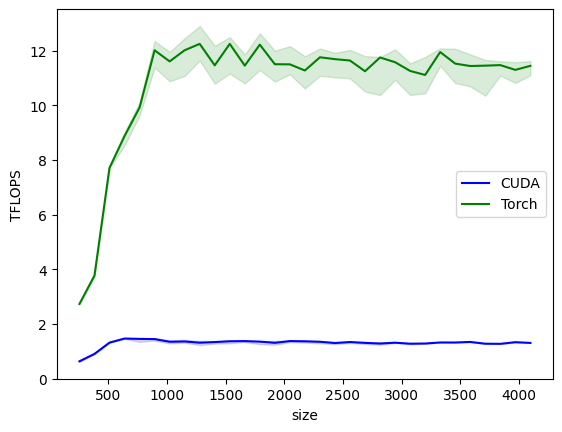

naive-cuda-matmul-perf:
      size      CUDA      Torch
0    256.0  0.632625   2.730667
1    384.0  0.903483   3.768843
2    512.0  1.316686   7.710118
3    640.0  1.465999   8.873003
4    768.0  1.452806   9.916480
5    896.0  1.445260  12.011139
6   1024.0  1.347919  11.604507
7   1152.0  1.358500  12.012255
8   1280.0  1.313281  12.245143
9   1408.0  1.336138  11.459706
10  1536.0  1.365766  12.244157
11  1664.0  1.371952  11.448998
12  1792.0  1.352248  12.217595
13  1920.0  1.308878  11.500832
14  2048.0  1.373507  11.496288
15  2176.0  1.365634  11.271286
16  2304.0  1.347746  11.754938
17  2432.0  1.301643  11.686322
18  2560.0  1.338343  11.636492
19  2688.0  1.307260  11.243588
20  2816.0  1.282699  11.747638
21  2944.0  1.314083  11.574297
22  3072.0  1.276043  11.255889
23  3200.0  1.283276  11.108670
24  3328.0  1.321669  11.945665
25  3456.0  1.320925  11.523952
26  3584.0  1.340900  11.435071
27  3712.0  1.276316  11.448855
28  3840.0  1.271702  11.468333
29  3968.0  1.33

In [16]:
benchmark.run(show_plots=True, print_data=True)

In [17]:
torch.cuda.empty_cache()